# Projet Annuel : Prédiction de différents type de terrains sportifs (Football, Basket, Rugby)

## Sujet choisi : La prédiction de différents types de terrain sportifs

## Première étape : Constitution du dataset

### Récupération des données via web-scraping

En ce qui concerne la constitution du dataset, la majorité des images de chaque classe ont été récupérées via un script de web-scraping écrit en python permettant de récupérer les images de chaque classe et de les télécharger.

### Filtre des images

Etant donné que ces images sont récupérées via web scraping, il y a eu des moments où certaines images ne correspondaient pas à ce qui était recherché (Problème de format, image non conforme etc). Cela a été l'étape la plus fastidieuse car cela devait être fait manuellement.

# Seconde étape : Implémentation des différents modèles demandés :

## Import des modules nécessaires

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ctypes
import sys
import os

### Définition de la variable d'environnement RUST_BACKTRACE permettant de récupérer la stacktrace de la librairie en cas d'erreur et faciliter le débogage

In [2]:
os.putenv("RUST_BACKTRACE", "full")

### Définition d'un dictionnaire permettant de récupérer l'éxecutable de la librairie peu importe l'os

In [9]:
computer_plateform = sys.platform
library_mapping = {
    "linux": r"./library/target/debug/liblibrary.so",
    "windows": r"./library/target/debug/liblibrary.dll",
    "darwin": r"./library/target/debug/liblibrary.dylib",
}

lib = ctypes.CDLL(library_mapping.get(computer_plateform))

## Modèle linéaire
Tout d'abord, on a décidé d'implémenter le modèle linéaire, afin de tester la validité du code écrit par notre groupe, on s'est servi des cas de test fourni par notre professeur.
Vous trouverez ci-dessous les cas de tests pour le modèle linéaire appliqué à la librairie qu'on a conçu.

### Cas de tests pour la classification

### Définition des structure utilisés dans la librairie afin d'appeler les fonction avec les bons types

In [ ]:
class LinearClassifier(ctypes.Structure):
    _fields_ = [
        ('weights', ctypes.POINTER(ctypes.c_float)),
        ('size', ctypes.c_size_t),
    ]

### Définition des types des paramètres de chaque fonction ainsi que le type de retour lorsque cela est nécessaire

In [ ]:
new_ml_arg_dict = {
    "num_features": ctypes.c_size_t
}
lib.new.argtypes = list(new_ml_arg_dict.values())
lib.new.restype = ctypes.POINTER(LinearClassifier)

train_regression_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'flattened_dataset_inputs': ctypes.POINTER(ctypes.c_float),
    'flattened_dataset_expected_outputs': ctypes.POINTER(ctypes.c_float),
    'len_input': ctypes.c_size_t,
    'len_output': ctypes.c_size_t,
}
lib.train_regression.argtypes = list(train_regression_arg_dict.values())
lib.train_regression.restype = None

train_classification_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'flattened_dataset_inputs': ctypes.POINTER(ctypes.c_float),
    'flattened_dataset_expected_outputs': ctypes.POINTER(ctypes.c_float),
    'len_input': ctypes.c_size_t,
    'len_output': ctypes.c_size_t,
    'lr': ctypes.c_float,
    'epochs': ctypes.c_int
}
lib.train_classification.argtypes = list(train_classification_arg_dict.values())
lib.train_classification.restype = None

predict_classification_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'inputs': ctypes.POINTER(ctypes.c_float),
    'inputs_size': ctypes.c_size_t,
}
lib.predict_classification.argtypes = list(predict_classification_arg_dict.values())
lib.predict_classification.restype = ctypes.c_float

predict_regression_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'inputs': ctypes.POINTER(ctypes.c_float),
    'inputs_size': ctypes.c_size_t,
}
lib.predict_regression.argtypes = list(predict_regression_arg_dict.values())
lib.predict_regression.restype = ctypes.c_float

lib.delete_linear_model.argtypes = [ctypes.POINTER(LinearClassifier)]
lib.delete_linear_model.restype = None

save_model_arg_dict = {
    "model": ctypes.POINTER(LinearClassifier),
    "filename": ctypes.c_char_p
}

lib.save_linear_model.argtypes = list(save_model_arg_dict.values())
lib.save_linear_model.restype = ctypes.c_int

load_model_arg_dict = {
    "path": ctypes.c_char_p
}

lib.load_linear_model.argtypes = list(load_model_arg_dict.values())
lib.load_linear_model.restype = ctypes.POINTER(LinearClassifier)

## Cas tests de classification

### Cas simple

In [ ]:
linear_classifier_object = lib.new(2)

X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
])
Y = np.array([
    1,
    -1,
    -1
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[x1, x2] for x1 in range(0, 5) for x2 in range(0, 5)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.31, 100000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = (ctypes.c_float * len(p))(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res1, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

lib.delete_linear_model(linear_classifier_object)

### Cas Multiple

In [ ]:
linear_classifier_object = lib.new(2)

X = np.concatenate(
    [np.random.random((50, 2)) * 0.9 + np.array([1, 1]), np.random.random((50, 2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0, np.ones((50, 1)) * -1.0])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[float(x1) / 6, float(x2) / 6] for x1 in range(0, 20) for x2 in
                       range(0, 20)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs),  0.00001, 100000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors[0:100], s=200)
plt.show()
lib.delete_linear_model(linear_classifier_object)


### XOR

In [ ]:
linear_classifier_object = lib.new(2)

X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[x1 / 15, x2 / 15] for x1 in range(0, 20) for x2 in range(0, 20)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 1000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_linear_model(linear_classifier_object)

### Cross

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

linear_classifier_object = lib.new(2)

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))


test_dataset_inputs = [[x1, x2] for x1 in range(0, 2) for x2 in range(0, 2)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 1000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors,s=2000)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=20)
plt.show()
lib.delete_linear_model(linear_classifier_object)

### Multi Linear 3 Classes

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [0, 0, 0] for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in X]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

linear_classifier_object = lib.new(3)

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[x1, x2] for x1 in range(-2, 2) for x2 in range(-2, 2)]
colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 1000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ["blue" if np.argmax(label) == 0 else ("red" if np.argmax(label) == 1 else "green") for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors,
            s=2000)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=20)
plt.show()
lib.delete_linear_model(linear_classifier_object)

### Multi Cross

In [ ]:
X = np.random.random((1000, 3)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else
              [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else
              [0, 0, 1] for p in X])

linear_classifier_object = lib.new(3)

test_dataset = [[x1, x2] for x1 in range(-2, 2) for x2 in range(-2, 2)]
predicted_colors = ["blue" if np.argmax(output) == 0
                    else ("red" if np.argmax(output) == 1 else "green") for output in Y]

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
print(len(flattened_inputs) // X.shape[1], len(flattened_outputs) // Y.shape[1])
lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs) // X.shape[1], len(flattened_outputs) // Y.shape[1], 0.1, 1000)


predicted_outputs = []
for p in test_dataset:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ["blue" if np.argmax(label) == 0 else ("red" if np.argmax(label) == 1 else "green") for
                            label in predicted_outputs]

plt.scatter(np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:, 0],
            np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:, 1],
            color='blue')
plt.scatter(np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:, 0],
            np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:, 1],
            color='red')
plt.scatter(np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:, 0],
            np.array(list(map(lambda elt: elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:, 1],
            color='green')
plt.show()
lib.delete_linear_model(linear_classifier_object)

## Cas de test de regression

### Linear Simple 2D

In [ ]:
X = np.array([
    [1],
    [2]
])
Y = np.array([
    2,
    3
])

test_dataset_inputs = list(map(lambda i: float(i), range(-10, 11)))

linear_regression_object = lib.new(1)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs),
                     len(flattened_outputs))

test_inputs = np.array(test_dataset_inputs, dtype=np.float32, order='C')
flattened_test_inputs = test_inputs.flatten()
arr_test_inputs = flattened_test_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

plt.plot([p[0] for p in test_dataset_inputs], predicted_outputs)
plt.scatter([p[0] for p in test_dataset_inputs], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_linear_model(linear_regression_object)

### Non Linear Simple 2D

In [ ]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])


test_dataset_inputs = list(map(lambda i: float(i), range(-10, 11)))

linear_regression_object = lib.new(2)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs),
                     len(flattened_outputs))

test_inputs = np.array(test_dataset_inputs, dtype=np.float32, order='C')
flattened_test_inputs = test_inputs.flatten()
arr_test_inputs = flattened_test_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

plt.plot([p[0] for p in test_dataset_inputs], predicted_outputs)
plt.scatter([p[0] for p in test_dataset_inputs], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_linear_model(linear_regression_object)


### Linear Simple 3D

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])


linear_regression_object = lib.new(2)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs),
                     len(flattened_outputs))

test_dataset_inputs = np.array([[a / 10, b / 10] for a in range(30) for b in range(30)])
predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
ax.scatter(test_dataset_inputs[:,0], test_dataset_inputs[:,1], predicted_outputs)
plt.show()
plt.clf()
lib.delete_linear_model(linear_regression_object)


### Linear Tricky 3D

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])


linear_regression_object = lib.new(2)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs),
                     len(flattened_outputs))

test_dataset_inputs = np.array([[a / 10, b / 10] for a in range(30) for b in range(30)])
predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
ax.scatter(test_dataset_inputs[:,0], test_dataset_inputs[:,1], predicted_outputs)
plt.show()
plt.clf()
lib.delete_linear_model(linear_regression_object)


### Non Linear Simple 3D

In [ ]:
X = np.array([
      [1, 1],
      [0,1],
      [1, 1],
      [0, 0]
])
Y = np.array([
      2,
      1,
      -2,
    -1
])


linear_regression_object = lib.new(2)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs),
                     len(flattened_outputs))

test_dataset_inputs = np.array([[a / 10, b / 10] for a in range(30) for b in range(30)])
predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
ax.scatter(test_dataset_inputs[:,0], test_dataset_inputs[:,1], predicted_outputs)
plt.show()
plt.clf()
lib.delete_linear_model(linear_regression_object)

# Perceptron multi couche

Ensuite on a implémenté le perceptron multi couche, afin de tester la validité du code écrit par notre groupe, on s'est servi des cas de test fourni par notre professeur.
Vous trouverez ci-dessous les cas de tests pour le modèle linéaire appliqué à la librairie qu'on a conçu.

### Définition des structure utilisés dans la librairie afin d'appeler les fonction avec les bons types

In [10]:
class Veci64(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(ctypes.c_int64)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vecf32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(ctypes.c_float)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vec2df32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(Vecf32)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vec3df32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(Vec2df32)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class PMC(ctypes.Structure):
    _fields_ = [
        ('layers', ctypes.c_size_t),
        ('dimensions', ctypes.POINTER(Veci64)),
        ('X', ctypes.POINTER(Vec2df32)),
        ('W', ctypes.POINTER(Vec2df32)),
        ('deltas', ctypes.POINTER(Vec2df32)),
    ]

### Définition des types des paramètres de chaque fonction ainsi que le type de retour lorsque cela est nécessaire

In [11]:
new_pmc_model_arg_dict = {
    "dimensions_arr": ctypes.POINTER(ctypes.c_int64),
    "layer_size_per_neuron": ctypes.c_size_t,
}
lib.new_pmc.argtypes = list(new_pmc_model_arg_dict.values())
lib.new_pmc.restype = ctypes.POINTER(PMC)

train_pmc_model_arg_dict = {
    "model": ctypes.POINTER(PMC),
    "dataset_inputs": ctypes.POINTER(ctypes.c_float),
    "dataset_inputs_size": ctypes.c_size_t,
    "flattened_dataset_outputs": ctypes.POINTER(ctypes.c_float),
    "dataset_outputs_size": ctypes.c_size_t,
    "alpha": ctypes.c_float,
    "epochs": ctypes.c_int32,
    "is_classification": ctypes.c_bool
}
lib.train_pmc_model.argtypes = list(train_pmc_model_arg_dict.values())
lib.train_pmc_model.restype = None

predict_pmc_model_arg_dict = {
    "model": ctypes.POINTER(PMC),
    "sample_inputs": ctypes.POINTER(ctypes.c_float),
    "is_classification": ctypes.c_bool
}
lib.predict_pmc_model.argtypes = list(predict_pmc_model_arg_dict.values())
lib.predict_pmc_model.restype = ctypes.POINTER(ctypes.c_float)

lib.delete_pmc_model.argtypes = [ctypes.POINTER(PMC)]
lib.delete_pmc_model.restype = None

save_pmc_model_arg_dict = {
    "model": ctypes.POINTER(PMC),
    "filename": ctypes.c_char_p
}

lib.save_pmc_model.argtypes = list(save_pmc_model_arg_dict.values())
lib.save_pmc_model.restype = ctypes.c_int

load_model_arg_dict = {
    "path": ctypes.c_char_p
}

lib.load_pmc_model.argtypes = list(load_model_arg_dict.values())
lib.load_pmc_model.restype = ctypes.POINTER(PMC)

get_X_len_arg_dict = {
    "model": ctypes.POINTER(PMC)
}
lib.get_X_len.argtypes = list(get_X_len_arg_dict.values())
lib.get_X_len.restype = ctypes.c_int

#### Cas Simple (KO)

In [12]:
X = np.array([[1, 1], [2, 3], [3, 3]])
Y = np.array([1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output == 1.0 else "red" for output in Y]

dimensions = [2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(
    pmc_model,
    arr_inputs,
    len(flattened_inputs),
    arr_outputs,
    len(arr_outputs),
    ctypes.c_float(0.0001),
    ctypes.c_int32(1000),
    ctypes.c_bool(True),
)

X_test = [[x1 / 10, x2 / 10] for x1 in range(10, 40) for x2 in range(10, 40)]
sample_inputs = np.array(X_test, dtype=np.float32)
flattened_inputs = sample_inputs.flatten()
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)
t = np.array([1.0, 1.0])
t_array_ctypes = (ctypes.c_float * len(t))(*t)
predicted_outputs_ptr = lib.predict_pmc_model(
    pmc_model,
    t_array_ctypes,
    ctypes.c_bool(True),
)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if label == 1.0 else "red" for label in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors, s=2)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
# lib.save_pmc_model(pmc_model, b"pmc.json")
lib.delete_pmc_model(pmc_model)

Epoch : 0 Loss : NaN
Epoch : 100 Loss : NaN
Epoch : 200 Loss : NaN
Epoch : 300 Loss : NaN
Epoch : 400 Loss : NaN
Epoch : 500 Loss : NaN
Epoch : 600 Loss : NaN
Epoch : 700 Loss : NaN
Epoch : 800 Loss : NaN
Epoch : 900 Loss : NaN
Epoch : 1000 Loss : NaN
Epoch : 1100 Loss : NaN
Epoch : 1200 Loss : NaN
Epoch : 1300 Loss : NaN
Epoch : 1400 Loss : NaN
Epoch : 1500 Loss : NaN
Epoch : 1600 Loss : NaN
Epoch : 1700 Loss : NaN
Epoch : 1800 Loss : NaN
Epoch : 1900 Loss : NaN
Epoch : 2000 Loss : NaN
Epoch : 2100 Loss : NaN
Epoch : 2200 Loss : NaN
Epoch : 2300 Loss : NaN
Epoch : 2400 Loss : NaN
Epoch : 2500 Loss : NaN
Epoch : 2600 Loss : NaN
Epoch : 2700 Loss : NaN
Epoch : 2800 Loss : NaN
Epoch : 2900 Loss : NaN
Epoch : 3000 Loss : NaN
Epoch : 3100 Loss : NaN
Epoch : 3200 Loss : NaN
Epoch : 3300 Loss : NaN
Epoch : 3400 Loss : NaN
Epoch : 3500 Loss : NaN
Epoch : 3600 Loss : NaN
Epoch : 3700 Loss : NaN
Epoch : 3800 Loss : NaN
Epoch : 3900 Loss : NaN
Epoch : 4000 Loss : NaN
Epoch : 4100 Loss : NaN
Epoc

RuntimeError: ffi_prep_cif_var failed

#### Cas Multiple (KO)

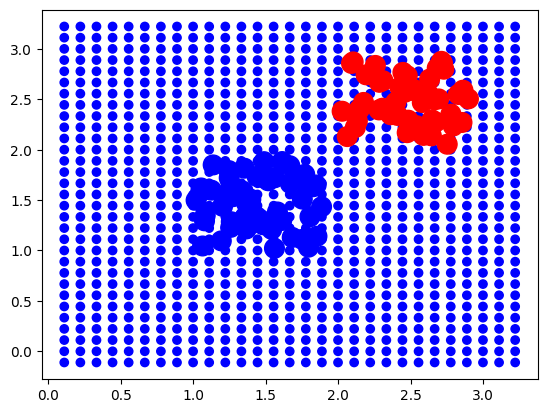

In [7]:
X = np.concatenate(
    [np.random.random((50, 2)) * 0.9 + np.array([1, 1]), np.random.random((50, 2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output >= 0 else "red" for output in Y]

dimensions = [2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = [[x1 / 9, x2 / 9] for x1 in range(1, 30) for x2 in range(-1, 30)]

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

#### XOR (KO)

In [ ]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output >= 0 else "red" for output in Y]

dimensions = [2, 2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = [[x1 / 10, x2 / 10] for x1 in range(-10, 20) for x2 in range(-10, 20)]

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

#### Multi Linear 3 classes

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [0, 0, 0] for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in
          Y]

dimensions = [2, 3]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = [[x1 / 10, x2 / 10] for x1 in range(-10, 10) for x2 in range(-10, 10)]

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

### Cross

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [0, 0, 0]for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in
          Y]

dimensions = [2,4, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = [[x1 / 10, x2 / 10] for x1 in range(-10, 10) for x2 in range(-10, 10)]

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

### Multi Cross

In [ ]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [0, 0, 1] for p in X])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in
          Y]

dimensions = [2,30,25, 3]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = [[x1 / 10, x2 / 10] for x1 in range(-10, 10) for x2 in range(-10, 10)]

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.scatter([p[0] for p in X_test], [p[1] for p in X_test], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

## Cas de test pour la regréssion

### Linear Simple 2D

In [ ]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [1,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.arange(-10,11)

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.plot(X_test, predicted_outputs)
plt.scatter([p[0] for p in X], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_pmc_model(pmc_model)

### Non Linear Simple 3D

In [ ]:
X = np.array([
      [1],
      [2],
    [3]
])
Y = np.array([
      2,
      3,
    2.5
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [1,3,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.arange(-10,11)

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.plot(X_test, predicted_outputs)
plt.scatter([p[0] for p in X], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_pmc_model(pmc_model)

### Linear Simple 3D

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [1,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.array(np.meshgrid(np.arange(30), np.arange(30))).T.reshape(-1, 2) / 10

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in X_test:
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.scatter(X_test[:, 0], X_test[:, 1], predicted_outputs)
ax.scatter(X[:, 0], X[:, 1], predicted_outputs)
fig.add_axes(ax)
plt.show()
plt.clf()
lib.delete_pmc_model(pmc_model)

### Linear Tricky 3D

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [1,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.arange(-10,11)

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])


fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.scatter(X_test[:, 0], X_test[:, 1], predicted_outputs)
ax.scatter(X[:, 0], X[:, 1], predicted_outputs)
fig.add_axes(ax)
plt.show()
plt.clf()
lib.delete_pmc_model(pmc_model)
lib.delete_pmc_model(pmc_model)

### Non Linear Simple 3D

In [ ]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [2,2,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.arange(-10,11)

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])


fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.scatter(X_test[:, 0], X_test[:, 1], predicted_outputs)
ax.scatter(X[:, 0], X[:, 1], predicted_outputs)
fig.add_axes(ax)
plt.show()
plt.clf()
lib.delete_pmc_model(pmc_model)
lib.delete_pmc_model(pmc_model)

### Non Linear Simple 3D

In [ ]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)


dimensions = [1,1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

X_test = np.arange(-10,11)

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(X_test)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]
plt.plot(X_test, predicted_outputs)
plt.scatter([p[0] for p in X], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_pmc_model(pmc_model)

## Mise en place de l'application

Afin de pouvoir montrer ce qui a été produit lors de ce projet, il nous a été demandé de mettre en place une application afin de démontrer la confirmité de l'implémentation des modèles demandés avec la possibilité de charger des nouvelles données au sein de nos modèles ou bien de sauvegarder ces dernier pour une utilisation future.

Vous trouverez ci-dessous quelques images de l'application conçue ainsi que la démonstration de certaines fonctionnalités